# Scenario 6: Measuring the stability of enzymes
Dataset provided by Amalie Vang Høst (Department of Chemical and Biochemical Engineering, Technical University of Denmark, 2800 Kgs Lyngby, Denmark)  
  
This Jupyter Notebook accompanies the sixth scenario of the paper: EnzymeML at work: seamless data flow and modelling of enzymatic data.  
In this scenario the time-course data from an EnzymeML document is analysed visually and initial rates are calculated.

## Imports <a class="anchor" name="Imports"></a>
All necessary Python packages are installed and imported.  
If you run this notebook with Binder you don't have to install anything, Binder takes care of this.  
In order to run on google Colaboratory (Colab), PyEnzyme will be installed and the dataset is loaded from GitHub. This is done in the first Code Cell.  
If you run this notebook local make sure you have all Packages installed and the dataset in the same directory as the notebook.

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+git://github.com/EnzymeML/PyEnzyme.git@feature/experiment-class
    !wget https://github.com/EnzymeML/Lauterbach_2021/raw/main/Scenario6/DeactivationOfGlucoseOxidase_Host.omex
else:
    print('Not running on Colab.')

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pyenzyme.enzymeml.tools import EnzymeMLReader

## Reading EnzymeML
In order to read the EnzymeML document and access its content with the PyEnzyme software the file path is defined.  
When running the next code cell the EnzymeML document is saved in the `enzmlDoc` variable and an overview is printed below.

In [2]:
path = 'DeactivationOfGlucoseOxidase_Host.omex'

# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    enzmlDoc = EnzymeMLReader().readFromFile(path)
else:
    print('Incorrect file path.')

print(enzmlDoc)

>>> Units
	ID: u0 	 Name: ml
	ID: u1 	 Name: mole / l
	ID: u2 	 Name: g / l
	ID: u3 	 Name: K
	ID: u4 	 Name: sec
>>> Reactants
	ID: s0 	 Name: Glucose
	ID: s1 	 Name: water
	ID: s2 	 Name: O2
	ID: s3 	 Name: 4-aminoantipyrine
	ID: s4 	 Name: 3,5-dichloro-2-hydroxybenzenesulfonic acid
	ID: s5 	 Name: Gluconic acid
	ID: s6 	 Name: pink product
>>> Proteins
	ID: p0 	 Name: Glucose Oxidase
>>> Reactions
	ID: r0 	 Name: Deactivation of glucose oxidase
>>> Measurements

ID    Species   Conc      Unit  
m0    p0        0.500   g / l   
m0    s0        1       mole / l
m0    s1        0       mole / l
m0    s2        0       mole / l
m0    s3        1       mole / l
m0    s4        10      mole / l
m0    s5        0       mole / l
m0    s6        0       mole / l
m1    p0        0.500   g / l   
m1    s0        1       mole / l
m1    s1        0       mole / l
m1    s2        0       mole / l
m1    s3        1       mole / l
m1    s4        10      mole / l
m1    s5        0       mole / l
m1

The overview showed which reactant corresponds to which id.  
Each measurement consists of 7 reactants and one protein (p0).
In this case all 11 measurements were carried out under identical conditions and with identical initial concentrations.  
The measurements took place after varied periods of time, this information was stored in the measurement names and is not shown in the overview.  
Next one measurement is exemplarily examined. 

In [3]:
# Fetch the measurement
measurement0 = enzmlDoc.getMeasurement('m0')
print(measurement0.getName())
reactants = measurement0.getReactants()

# Access the measurement data per reactant/protein
speciesType = "reactants" # "proteins"
for reactantID, data in reactants.items():
    # Extract all the data
    speciesID = data.getReactantID() if speciesType == "reactants" else data.getProteinID()
    initConc = data.getInitConc()
    unitID = data.getUnit()
    unitString = enzmlDoc.getUnitString(unitID)
    replicates = data.getReplicates()
    print(
        f"{speciesID}: InitConc = {initConc} {unitString} ; NumReplicates = {len(replicates)}"
    )

initial Measurement
s0: InitConc = 1.0 mole / l ; NumReplicates = 0
s1: InitConc = 0.0 mole / l ; NumReplicates = 0
s2: InitConc = 0.0 mole / l ; NumReplicates = 0
s3: InitConc = 1.0 mole / l ; NumReplicates = 0
s4: InitConc = 10.0 mole / l ; NumReplicates = 0
s5: InitConc = 0.0 mole / l ; NumReplicates = 3
s6: InitConc = 0.0 mole / l ; NumReplicates = 0


The overview of the initial measurement shows that the product Gluconic acid (s5) has 3 replicates.  
Most initial concentrations are 0 and of no interest for our analysis.

## Data preparation
In this experiment to analyse the stability of the enzyme only the change of the initial rates over time is of interest. Therefore only the measured time course data and the measurement names containing the time information are stored for each measurement. In order to extract the information of the measurement time string manipulation is used. Since the first measurement name doesn't follow the naming scheme it is renamed.

In [4]:
# rename initial measurement
enzmlDoc.getMeasurement('m0').setName('Measurement after 0 min')

# initialise datastructure to store experimental data
experimentalData = []

# time and substrate concentration unit
time = np.array(enzmlDoc.getMeasurement('m0').getGlobalTime(), float)
timeUnit = enzmlDoc.getUnitDict()[enzmlDoc.getMeasurement('m0').getGlobalTimeUnit()].getName()
concentrationUnit = ''

# go through all measurements:
for measurement in enzmlDoc.getMeasurementDict().values():
    name = measurement.getName()
    measurementData = {
        'name': name,
        'measuring time min': float(name.split(' ')[-2]),
        'measuring time h': float(name.split(' ')[-2])/60,
        'measured': []
    }

    # get replicates with time course data:
    reactant = measurement.getReactant('s5')
    replicates = reactant.getReplicates()
    for replicate in replicates:
        measurementData['measured'].append(replicate.getData().values.tolist())
    experimentalData.append(measurementData)

## Visualisation of time-course data
All time-course data is visualised with the Python library matplotlib.  
In order to save the figures as svg uncomment the `plt.savefig(...)` code lines. 

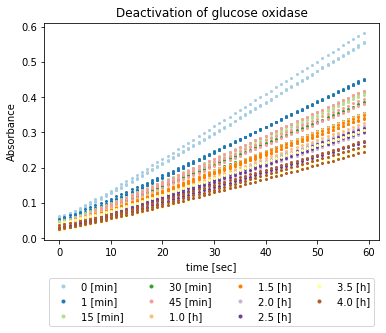

In [5]:
# define colors for time-course visualisation
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
# plot time course data with matplotlib
reaction_name = enzmlDoc.getReaction('r0').getName()
plt.figure()
ax = plt.subplot()
for i in range(len(experimentalData)):
    t = experimentalData[i]['measuring time min']
    if t < 60:
        ax.plot([], 'o', ms=3, label=str(int(t)) + ' [min]', color = colors[i])
    else:
        ax.plot([], 'o', ms=3, label=str(t/60) + ' [h]', color = colors[i])
    for measurement in experimentalData[i]['measured']:
        ax.plot(time, measurement, 'o', ms=2, color = colors[i])
plt.title(reaction_name)
ax.set_xlabel('time ['+timeUnit+']')
ax.set_ylabel('Absorbance')
plt.legend(bbox_to_anchor=(0, 0, 1, -0.15), mode="expand", ncol=4)
# save as svg
#plt.savefig('time-course.svg', bbox_inches='tight')
plt.show()

## Computation of initial rates
To calculate the initial rates the slope of the first 30 datapoints (0 to 29 seconds) for each replicate was calculated, to be consistent with the calculations done by Vang Host (paper?). This was done with linear regression by the Python library SciPy.  
In order to calculate the slope of another fraction of the time-course change the `start` and `end` variable accordingly, `end` should not be greater than 59.  
Then the mean from the 3 replicates was calculated for each measurement and saved in `experimentalData`.  
With an extinction coefficient of 26 the rates were determined as follows: $ rate = \frac{meanOfSlope}{26}*1000$  
and also stored in `experimentalData`.  
And finally the residual activity compared to the initial activity is calculated and stored as well.

In [6]:
start = 0
end = 29
for measurement in experimentalData:
    slopes = []
    for replicate in measurement['measured']:
        slope, intercept, r, p, se = stats.linregress(time[start:end], replicate[start:end])
        slopes.append(slope)
    slope = np.mean(slopes)
    measurement['slope'] = round(slope, 4)
    measurement['v0'] =  round(slope/(26)*1000, 3)
    measurement['residual activity'] = measurement['v0']/experimentalData[0]['v0']*100

## Visualisation of the rates
First the rates are plotted over the time.

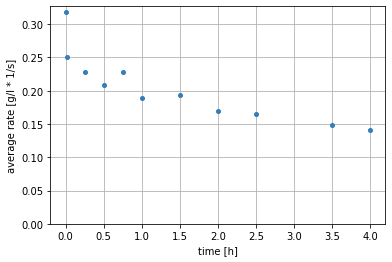

In [7]:
plt.figure()
ax = plt.subplot()
for measurement in experimentalData:
    ax.plot(measurement['measuring time h'], measurement['v0'], 'o', ms=4, color='#377eb8')
ax.set_xlabel('time [h]')
ax.set_ylabel('average rate [g/l * 1/s]')
ax.set_ylim(ymin=0)
ax.grid(True)
# save as svg
#plt.savefig('rates.svg', bbox_inches='tight')
plt.show()

Second the residual of the rates is plotted.

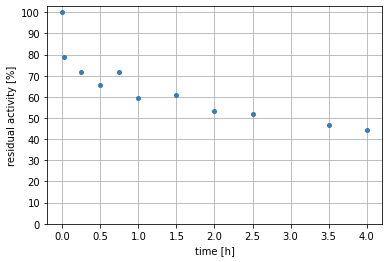

In [8]:
plt.figure()
ax = plt.subplot()
for measurement in experimentalData:
    ax.plot(measurement['measuring time h'], measurement['residual activity'], 'o', ms=4, color='#377eb8')
ax.set_xlabel('time [h]')
ax.set_ylabel('residual activity [%]')
ax.set_yticks(np.arange(0, 105, 10))
ax.grid(True)
# save as svg
#plt.savefig('residual-activity.svg', bbox_inches='tight')
plt.show()

## Upload to DaRUS
Finally the EnzymeML document is uploaded to the DaRUS dataverse.

In [10]:
API_Token = input('Enter API Token')

In [11]:
enzmlDoc.uploadToDataverse(
    baseURL="https://darus.uni-stuttgart.de/",
    API_Token= API_Token,
    dataverseName="enzymeml_at_work"
)

Dataset with pid 'doi:10.18419/darus-2197' created.
